# __<font color=blue> Chemotaxis Index (CI) Analysis</font>__

This notebook will process '.txt' comma seperated files into values and stats of chemotaxis indices.  
Please label files as DD_MM_conditon/strain name_replicate if applicable.txt


### Importing modules

In [1]:
import csv
import os
import math
import re
import numpy as np

import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
from matplotlib import cm

import pandas as pd
import scipy
from scipy.stats import ttest_ind
import seaborn as sns


### Importing file directory of dataset

In [2]:
#Importing the file path of all files in local  and sub directories
def import_test():
    data_out=[]
    #files
    root=os.getcwd() #saving starting point
    filesSub=(os.listdir())
    filesSub=sorted(filesSub, key=len) #sorting numerically
    keepList=[]
    for i in filesSub: 
        if re.search("txt*", i): #getting rid of .ipbyn files in directory
            keepList.append(i)
    filesSub=(keepList)
    
    #strain names
    name_directory = [k[6:len(k) - 4].split('_')[0] for k in filesSub]  #removing date and ".csv", aka the strain names
    for i in filesSub:
        data_out.append(np.loadtxt(i))
    return data_out, name_directory

data_out, name_directory=import_test()
print(name_directory)

['pf18', 'CC-125', 'pf18', 'pf18', 'CC-125', 'CC-125']


### Helper functions

In [3]:
def pval(p_value):
    'convert p-vals to astrixes'
    if p_value < 0.001:
        significance = '***'
    elif p_value < 0.01:
        significance = '**'
    elif p_value < 0.1:
        significance = '*'
    else:
        significance = ' '
    return significance

def z_factor(data_pos, data_neg):
    '''1= idea, 1-0.5= good assay, 0-0.5= marginal less that 0 = bad
    https://en.wikipedia.org/wiki/Z-factor'''
    SD_pos=np.std(data_pos)
    SD_neg=np.std(data_neg)
    AVG_pos=np.mean(data_pos)
    AVG_neg=np.mean(data_neg)
    print(len(data2), len(data1))
    ZFAC=(3*((AVG_pos-SD_pos/np.sqrt(len(data_pos)))-(AVG_neg-SD_neg/np.sqrt(len(data_neg))))/(AVG_pos-AVG_neg))
    return ZFAC

def cohens_effect_size(d1, d2):
    n1, n2 = len(d1), len(d2)
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2)) # calculate the pooled standard deviation
    u1, u2 = np.mean(d1), np.mean(d2) # means
    return (u1 - u2) / s # calculates the effect size

def convert_to_table(df, averageBY='strain', print_count=True, print_LaTex=False, stat_test=None,z_Factor=False,
                     control=None):
    """
    Convert a DataFrame into a table of averages, standard deviations and p-values.

    Args:
        df (pd.DataFrame): The input type. #I WANT TO ADD A LIST LATER
        average_by (str): The column name to average by.
        print_count (bool): Whether to print total track count. Default: False.
        print_latex (bool): Whether to print LaTeX table. Default: False.
        stat_test (str): The statistical test to perform. Default: None.
            Options: 1. ttest_ind, 2. ks_2samp
        control (str): The control group for statistical test. Default: None.

    Returns:
        styler (pd.io.formats.style.Styler): The styled DataFrame.
        final_df (pd.DataFrame): The final DataFrame with raw averages, stds, and p-values.
    """
    if isinstance(df, list):
        #if it is a list then convert to a df and then pass to rest of function. not written yet. 
        pass
    
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a DataFrame.")
    
    if averageBY not in df.columns:
        raise ValueError("Invalid 'averageBY' column name.")
        
    if stat_test is not None and control is None or stat_test is  None and control is not None:
        raise ValueError("If either 'stat_test' or 'control' is passed, the other must also be specified.")

    final_df=[] #empty df to append to
    df= pd.DataFrame(df) #making a copy
    
    #df.reset_index(inplace=True) #sometime the index may be what is needed for the averageBY varialble
    column=list(df.columns) #getting column names
    column = [ele for ele in column if ele not in ['strain', 'index', 'file', 'index_0']]

    for category in column:
        category_df=df[[category,averageBY]]
        table_output = category_df.groupby(averageBY).mean()
        table_output['STD'] = category_df.groupby(averageBY).std()
        if print_count==True: 
            table_output['total track count'] = category_df.groupby(averageBY).count() 

        if pd.isna(table_output['STD']).all(): #if replicates are not present, then STD is ignored
            del table_output['STD']
            final_df.append(table_output)
        elif control and stat_test is not None: 
            pvalList=[]
            effectSizeList=[]
            if z_Factor is True: 
                for i in np.unique(df['strain']):
                    data2=list((df.loc[df['strain'] == i, category]).dropna())
                    data1=list((df.loc[df['strain'] == control, category]).dropna())
                    z_FAC=z_factor(data1, data2)
                    print(i, category, z_FAC)
            if stat_test is not None:
                for i in np.unique(df['strain']):
                    data1=list((df.loc[df['strain'] == i, category]).dropna())
                    data2=list((df.loc[df['strain'] == control, category]).dropna())
                    effectSize=cohens_effect_size(data1,data2)
                    effectSizeList.append(effectSize)
                    if stat_test=='ks_2samp':
                        stats=scipy.stats.ks_2samp(data1,data2)
                        pvalList.append(stats.pvalue)
                    elif stat_test=='ttest_ind':
                        stats=scipy.stats.ttest_ind(data1,data2)
                        if 0.25>np.var(data1)/np.var(data2)>4: 
                            print('Warning, variances unequal. Consider unsing a Welch''s T-test')
                        pvalList.append(stats.pvalue) 
                    else: 
                        'Invalid statistical test selected. Options are: ks_2samp, ttest_ind.'      
                table_output['p-value']=pvalList
                table_output['cohen''s effect size']=effectSizeList
                index = [(category, level) for level in ['mean ± std', 'P-value', 'cohen''s effect size', 'count']]
                index = pd.MultiIndex.from_tuples(index, names=[" ", "  "]) #or parameter, values
                table_output_style = pd.DataFrame([table_output[category].round(3).astype(str) + " ± " +
                                        table_output["STD"].round(3).astype(str), table_output['p-value'].astype(str), 
                                        table_output['cohen''s effect size'].astype(str), table_output['total track count']],
                                        index=index, columns=table_output.index)
                table_output_style = table_output_style.transpose()
                final_df.append(table_output_style)
            
        else: 
            table_output_style = pd.DataFrame(table_output[category].round(3).astype(str) + " ± " +
                    table_output["STD"].round(3).astype(str),
                    index=table_output.index, columns=[category+' mean ± std'])
            final_df.append(table_output_style)
                
    final_df = pd.concat(final_df, axis=1)
    styler = final_df.style
    styler = styler.set_properties(subset=styler.columns[1:], **{'text-align': 'right'})
    styler.set_table_styles([{'selector': 'tr',
                                  'props': [('font-family', 'Arial')]}])
    if print_LaTex==True:
        latex=final_df.style.to_latex(position="h", position_float="centering",
                hrules=True, label="table:5", caption="Styled LaTeX Table",
                multirow_align="c", multicol_align="c")  
        print(latex)  
        print('To render copy and paste into https://www.overleaf.com/,  in mode: <usepackage{booktabs}>')
    return styler, final_df
    
def slope(x, b, c):
    return b*x + c

### Functions to calculate the chemotactic index

In [4]:
def intensity_normalized_by_mean(dataset, strain, bins=5):
    '''method to accept one array of a lane/dataset and BIN (to smooth data) into CI
    the bin index must be odd'''
    crop=(round(dataset.shape[1]/8)) #cropping the outer edges of the agar: 
    dataset=dataset[:,crop:-crop]
    splitData=np.array_split(dataset, bins, axis=1)

    #normalizing to 1 at t=0:
    normalList=[]
    timeLength=splitData[0].shape[0]
    for i in range(0,len(splitData)):
        zeroNorming=splitData[i][1]
        FillData=zeroNorming/zeroNorming
        for iterate in range(1, len(splitData[i])): 
            #currrently looping through all time times in one bin, then the next and next
            normalizedData=(splitData[i][iterate])/(zeroNorming)        
            FillData=np.append(FillData, normalizedData, 0) #add to a numpy array first
        FillData=np.asarray(np.split(FillData, len(splitData[i])))
        normalList.append(FillData) #then a list
        FillData=[]
        zeroNorming=[]
    
    #finding mean in bin
    meanArray=[]
    for time in range(0,normalList[1].shape[0]):
        array=normalList[0][time]
        for bin1 in range(1,bins):
            array=np.append(normalList[bin1][time], array)
        meanArray=np.append(meanArray, np.mean(array))
        array=[]               
    CIOut=[] #initializing
    for x in range(0,bins):
        meanBin=-100*((np.mean(normalList[x],1)-(meanArray))/(meanArray)) # should be sum, not mean originally, may cause isuue
        CIOut.append(meanBin)
    return CIOut

def slope_index(CIOut, strain, bins=5):
    #creating TI, a list centered on zero
    TiList=[]
    x=np.array([*(range(0,bins))])-((bins-1)/2)
    CIOut=np.array(CIOut)
    for time in range(0,CIOut[1].size):
        y=CIOut[:, time]
        popt, pcov=scipy.optimize.curve_fit(slope, x, y)
        TiList.append(popt[0])          
    return(TiList)

def chemotactic_index(TiList,strain):
    '''Final tactic index: choosing the maximum slope for each strain'''
    TI=max(TiList)
    return TI

In [5]:
def processingAndPlotting(data_out, names_out):
    normed_list, slope_list, chemotaxis_list=[], [], []
    #looping by trial
    for i, values in enumerate(data_out):
        strain = names_out[i]
        oneArray=values
        normed_intensity = intensity_normalized_by_mean(oneArray, strain, bins=20)
        slope_data = slope_index(normed_intensity, strain, bins=20)
        chemotactic_indices = chemotactic_index(slope_data, strain)
        
        #appending to list that will be used by dataframe
        normed_list.append((strain, normed_intensity, strain))
        slope_list.append((strain, slope_data, strain))
        chemotaxis_list.append((strain, chemotactic_indices, strain))
    #filling dataframe
    normed_list = pd.DataFrame(normed_list, columns=['strain', 'CI', 'trial'])
    slope_list = pd.DataFrame(slope_list, columns=['strain', 'TI', 'trial'])
    chemotaxis_list = pd.DataFrame(chemotaxis_list, columns=['strain', 'Tactic Index', 'trial'])
    
    return chemotaxis_list, normed_list, slope_list

data, CiList, TI_List=processingAndPlotting(data_out, name_directory)
print(data)

   strain  Tactic Index   trial
0    pf18      1.493083    pf18
1  CC-125      4.167988  CC-125
2    pf18      1.188568    pf18
3    pf18      1.346062    pf18
4  CC-125      5.724193  CC-125
5  CC-125      4.850110  CC-125


### Plotting the normalized change in intensity at each bin and time point

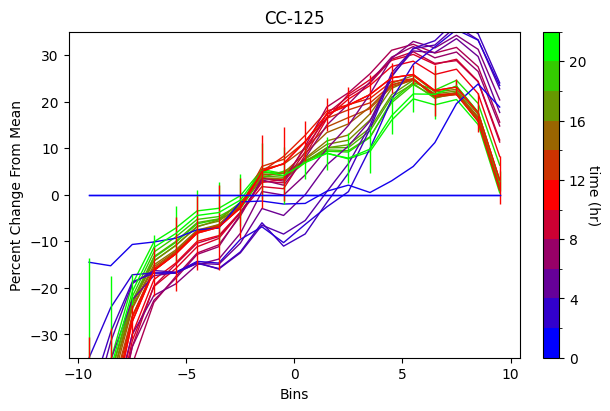

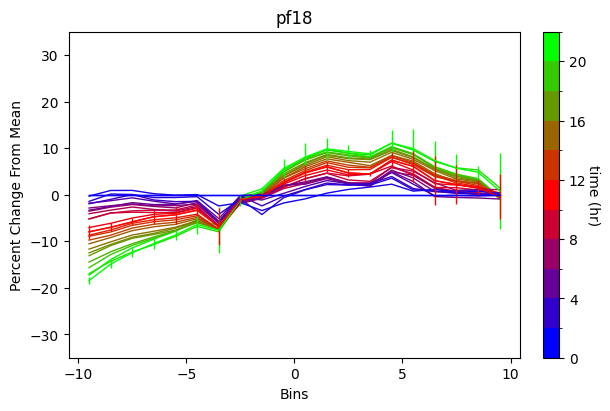

In [6]:
fileDict = {'sample name': 'new name'}

df=pd.DataFrame(CiList, columns=['strain', 'CI'])
df['strain'] = df['strain'].map(fileDict).fillna(df['strain'])
df['CI'] = df['CI'].apply(np.array)
df['CI'] = df['CI'].apply(lambda arr: arr[:, :-1] if arr.shape[1] > 48 else arr)
meanDF = df.groupby('strain')['CI'].mean()

# Group by 'strain'
grouped = df.groupby('strain')['CI']
# Initialize lists to store mean and standard deviation for each group
meanCI = []
stdCI = []
# Calculate mean and standard deviation for each group of 'CI' arrays
for i, group in grouped:
    meanCI.append([i, np.mean(group.tolist(), axis=0)])
    stdCI.append([i, np.std(group.tolist(), axis=0)])
#use the meaCI as a control, and compare to the other method to make sure this is correct
meanDF=pd.DataFrame(meanCI, columns=['strain', 'CI'])
stdDF=pd.DataFrame(stdCI, columns=['strain', 'CI'])
bins=20
centeredList=(np.array([*(range(0,bins))])-((bins-1)/2))
x=centeredList

for index, row in meanDF.iterrows():
    STD_values=stdDF.iloc[index]
    STD_values = np.array(STD_values['CI'].tolist())
    index=row['strain']
    ci_values = row['CI']
    numpy_array = np.array(ci_values.tolist())
    fig1, ax = plt.subplots(1, 1, figsize=(6,4), constrained_layout=True)
    my_cmap=plt.cm.brg(np.linspace(0,1,48))
    norm = mpl.colors.BoundaryNorm(np.arange(0, 24, 2), 256)
    
    for i in reversed(range(0,48,2)):
        ax.plot(x,numpy_array[:,i],color=my_cmap[i], linewidth=1)
    for i in reversed([1,24,47]):
        ax.errorbar(x, numpy_array[:, i], yerr=STD_values[:, i], color=my_cmap[i], linewidth=1)
        
    cax, cbar_kwds = mpl.colorbar.make_axes(ax, location = 'right',fraction=0.17, aspect=20)
    ax.set_ylabel("Percent Change From Mean")
    ax.set_xlabel("Bins")
    ax.set_ylim(-35, 35)
    ticks =[0,4,8,12,16,20,24]
    cb1 = mpl.colorbar.ColorbarBase(ax=cax, cmap='brg',norm=norm,orientation='vertical',ticks=ticks,)
    cb1.set_label('time (hr)', rotation=270, labelpad=10)  
    ax.set_xticks([-10,-5,0,5,10]) 
    ax.set_title(index)
    plt.show()
    

### Plotting the slope of (intensity/bin)

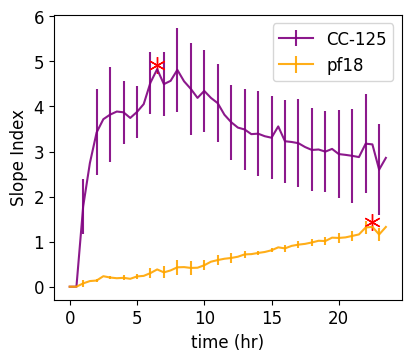

In [18]:
# PREPROCESSING
df=TI_List
df['strain'] = df['strain'].map(fileDict).fillna(df['strain'])
df['TI'] = df['TI'].apply(np.array)
df['TI'] = df['TI'].apply(lambda arr: arr[:-1] if len(arr) > 48 else arr) #
df=df.reset_index()

# TAKING TI LIST AVERAGES across trials
value_df = pd.DataFrame(df['TI'].to_list())
std_df = value_df.groupby(df['strain']).std()
mean_df = value_df.groupby(df['strain']).mean()

#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#PLOTTING ALL STRAINS- example of how idex found
x=np.arange(0,24,0.5)
fig1, ax = plt.subplots(1, 1, figsize=(4,3.5), constrained_layout=True)
CC125=(mean_df.loc['CC-125'])
CC125_err=(std_df.loc['CC-125'])
PF18=(mean_df.loc['pf18'])
PF18_err=(std_df.loc['pf18'])
ax.errorbar(x, CC125,  yerr=CC125_err, linewidth=1.5, errorevery=2, label='CC-125', c='purple', alpha=0.9)
ax.errorbar(x, PF18, linewidth=1.5, yerr=PF18_err, errorevery=2, label='pf18', c='orange', alpha=0.9)
max_PF = np.argmax(PF18)
plt.plot(x[max_PF], PF18[max_PF]+0.1, marker=(6, 2), color='red', markersize=12)
#__
max_CC125 = np.argmax(CC125)
plt.plot(x[max_CC125], CC125[max_CC125]+0.1, marker=(6, 2), color='red', markersize=12)

plt.xlabel('time (hr)')
plt.ylabel('Slope Index')
plt.legend()
plt.show()


### Plotting the chemotactic index and stats

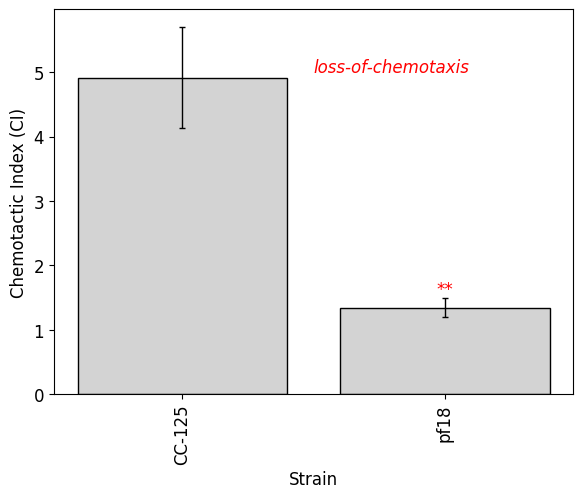

In [19]:
df=data #creating a copy
df=df.drop('trial', axis=1)

df['Tactic Index']=df['Tactic Index'].astype(float) #converting to numeric
df=df.sort_values(by=['strain'])
df=df.set_index('strain')
df=df.rename(index=fileDict)

# SORTING DF BY MEAN CI
grouped_df = df.groupby('strain')['Tactic Index'].mean().reset_index()
sorted_df = grouped_df.sort_values(by='Tactic Index', ascending=False)
high_to_low=(sorted_df['strain']).values
df = pd.merge(df, sorted_df, on='strain')
df = df.sort_values('Tactic Index_y', ascending=False)
df=df.drop('Tactic Index_y', axis=1)
df=df.rename({'Tactic Index_x': 'Tactic Index'}, axis=1)

#TABLE OUTPUT
a, b=convert_to_table(df, control='CC-125', stat_test='ttest_ind')
display(a)

#FORMATTING P-VALUES
pvalues=b['Tactic Index']['P-value']
pvalues=pvalues.reindex(high_to_low)
pvalues=[pval(float(i)) for i in pvalues]

#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#BARPLOT

#MEAN FOR BARPLOT
df=df.set_index('strain')
dfMean=df.groupby(level='strain', sort=False).mean(numeric_only=True)
dfSTD=df.groupby(level='strain', sort=False).std(numeric_only=True) 

fig, ax = plt.subplots(figsize=(6.7, 5))
plt.rcParams.update({'font.size': 12})
strainslist=dfMean.index
hbars=ax.bar(strainslist, dfMean['Tactic Index'], yerr=dfSTD['Tactic Index'], align='center', capsize=2, width=0.8, edgecolor="k", color='lightgrey', error_kw=dict(lw=1))
height=(dfMean+dfSTD).to_numpy()
for i,rect in enumerate(hbars):
    plt.text(rect.get_x() + rect.get_width() / 2.0, height[i], pvalues[i], ha='center', va='bottom', fontsize=12, color='r')
plt.xlabel("Strain",fontdict={'size':12})
plt.xticks(rotation=90)
test=('loss-of-chemotaxis')
plt.ylabel('Chemotactic Index (CI)',fontdict={'size':12})
plt.text(0.5,5,test, color='r', style='italic')
plt.show()

#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#saving indices externally
dfMean.to_csv(r'TacticIndex.csv', index=True)

# Use these blocks to process the high throughput screening data

In [12]:
data, CiList, TI_List=processingAndPlotting(alternate_directory)

Shape of imported array: (49, 305, 20)
Strains in current trial: ['pf18', 'CC-5448', 'CC-5443', 'CC-125']
2023_01_12_chemotaxis_5448 TRIAL_1

Shape of imported array: (49, 501, 30)
Strains in current trial: ['pf18', 'ptx1', 'ppr2', 'CC-5499', 'CC-5437', 'CC-5431', 'CC-5428', 'CC-2377', 'CC-125', 'ALT6']
2023_02_11_chemotaxis_allstrain TRIAL_1

Shape of imported array: (49, 471, 30)
Strains in current trial: ['ALT6', 'CC-124', 'CC-125', 'CC-2377', 'CC-5428', 'CC-5437', 'CC-5499', 'ppr2', 'ptx1', 'pf18']
2023_02_11_chemotaxis_allstrain TRIAL_3



C:\Users\lexis\AppData\Local\Temp\ipykernel_24056\1247839573.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels([' ', 'L', 'M', 'R'])


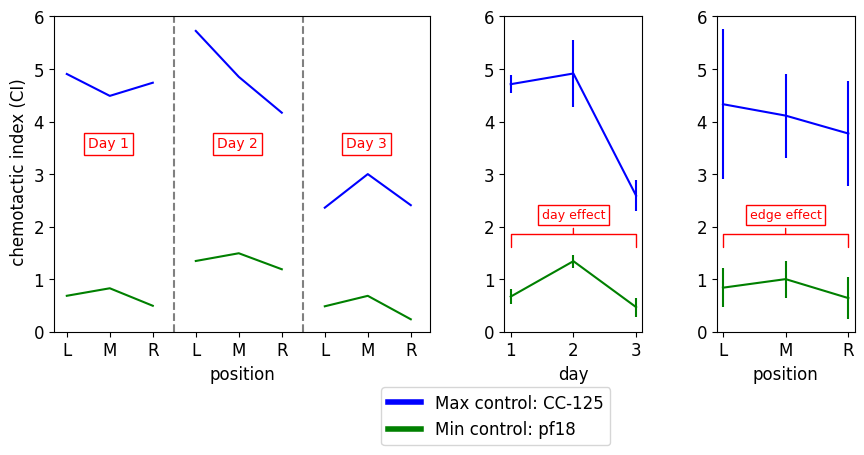

,z',"day effect (max, min)","edge effect (max, min)"
condition,,,
day 1,0.985056,"15.700, -19.142",--
day 2,0.751416,"20.701, 62.528",--
day 3,0.911677,"-36.400, -43.386",--
Left (L),0.472473,--,"6.351, 1.417"
Middle (M),0.750746,--,"1.014, 21.160"
Right (R),0.673839,--,"-7.364, -22.577"
pooled data,0.698692,--,--


In [13]:
fig, ax = plt.subplots(1, 3, figsize=(9, 4), width_ratios=[3, 1.1,1.1])
fig.tight_layout(pad=1.50)

#plotting indivudiual days/positions
count=1
maxlist,minlist=[],[]
for name, group in data.groupby('trial'):
    # 2 trials of three replicates each. 
    maxData=list(group.loc[group['strain'] == 'CC-125']['Tactic Index'])
    minData=list(group.loc[group['strain'] == 'pf18']['Tactic Index'])
    if len(minData)>3:
        minData=[minData[0], minData[1], minData[3]]
        maxData=[maxData[0], maxData[1], maxData[3]]
    x=[count+1,count+2,count+3]
    ax[0].plot(x, maxData, label=name, color='b')
    ax[0].plot(x, minData, label=name, color='g')
    ax[0].axvline(x = 3.5+count, color = 'grey', linestyle='dashed')

    maxlist.append(list(maxData))
    minlist.append(list(minData))
    count+=3

#PLOTTING BY DAY
min_std=(np.std(np.array(minlist),  axis=1))
max_std=(np.std(np.array(maxlist),  axis=1))
averageByDay_min=(np.mean(np.array(minlist),  axis=1))
averageByDay_max=(np.mean(np.array(maxlist),  axis=1))
ax[1].errorbar([1,2,3],averageByDay_min, yerr=min_std, color='g')
ax[1].errorbar([1,2,3],averageByDay_max, yerr=max_std, color='b')
ax[1].set_xlabel('day')

#PLOTTING BY POSITION
min_std=(np.std(np.array(minlist),  axis=0))
max_std=(np.std(np.array(maxlist),  axis=0))
averageByDay_min=(np.mean(np.array(minlist),  axis=0))
averageByDay_max=(np.mean(np.array(maxlist),  axis=0))    
ax[2].errorbar([1,2,3],averageByDay_min, yerr=min_std, color='g')
ax[2].errorbar([1,2,3],averageByDay_max, yerr=max_std, color='b')
ax[2].set_xlabel('position')
ax[2].set_xticklabels([' ', 'L', 'M', 'R'])

#FORMATTING GRAPH
from matplotlib.lines import Line2D 
ax[0].text(2.5, 3.5, s='Day 1', fontsize=10, color='r', bbox=dict(boxstyle='square', fc='white', color='r'))
ax[0].text(5.5, 3.5, s='Day 2', fontsize=10, color='r', bbox=dict(boxstyle='square', fc='white', color='r'))
ax[0].text(8.5, 3.5, s='Day 3', fontsize=10, color='r', bbox=dict(boxstyle='square', fc='white', color='r'))
ax[0].set_xticks(np.arange(2,11))
ax[0].set_xlabel('position')
ax[0].set_ylabel(' chemotactic index (CI)')
ax[0].set_xticklabels(['L', 'M', 'R','L', 'M', 'R','L', 'M', 'R' ])
custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='g', lw=4)]
ax[0].legend(custom_lines, ['Max control: CC-125', 'Min control: pf18'], bbox_to_anchor=(1.5, -0.15))
ax[0].set_xlim(1.7, 10.45)
ax[1].set_ylim(0, 6)
ax[2].set_ylim(0, 6)
ax[0].set_ylim(0, 6)
ax[1].annotate('day effect', xy=(0.5, 0.30), xytext=(0.5, 0.35), xycoords='axes fraction', 
            fontsize=9, ha='center', va='bottom', color='r',
            bbox=dict(boxstyle='square', fc='white', color='r'),
            arrowprops=dict(arrowstyle='-[, widthB=5, lengthB=1', lw=1.0, color='r'))
ax[2].annotate('edge effect', xy=(0.5, 0.30), xytext=(0.5, 0.35), xycoords='axes fraction', 
            fontsize=9, ha='center', va='bottom', color='r',
            bbox=dict(boxstyle='square', fc='white', color='r'),
            arrowprops=dict(arrowstyle='-[, widthB=5, lengthB=1', lw=1.0, color='r'))
plt.show()

#DATA TABLE PROCESSING++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#Z' by day effects:
maxlist=np.array(maxlist)
minlist=np.array(minlist)
zPrimeDay=[]
for i in range(0,3):
    zPrime=(np.mean(maxlist[i])-3*np.std(maxlist[i])/np.sqrt(3))-(np.mean(minlist[i])-3*np.std(minlist[i])/np.sqrt(3))
    zPrime=zPrime/(np.mean(maxlist[i])-np.mean(minlist[i]))
    zPrimeDay.append(zPrime)

#Z' by edge effects:
zPrimeEdge=[]
for i in range(0,3):
    zPrime=(np.mean(maxlist[:, i])-3*np.std(maxlist[:, i])/np.sqrt(3))-(np.mean(minlist[:, i])-3*np.std(minlist[:, i])/np.sqrt(3))
    zPrime=zPrime/(np.mean(maxlist[:, i])-np.mean(minlist[:, i]))
    zPrimeEdge.append(zPrime)

#Pooled z':
zPrime=(np.mean(maxlist)-3*np.std(maxlist)/np.sqrt(9))-(np.mean(minlist)-3*np.std(minlist)/np.sqrt(9))
pooled_Prime=zPrime/(np.mean(maxlist)-np.mean(minData))

#edge effect:
min_std=100*((np.mean(np.array(minlist),  axis=0))-np.mean(minlist))/np.mean(minlist)
max_std=100*((np.mean(np.array(maxlist),  axis=0))-np.mean(maxlist))/np.mean(maxlist)
edgeList=list(zip(max_std,min_std))
edgeList = [f"{max_val:.3f}, {min_val:.3f}"for max_val, min_val in edgeList]

#day effect:
min_std=100*((np.mean(np.array(minlist),  axis=1))-np.mean(minlist))/np.mean(minlist)
max_std=100*((np.mean(np.array(maxlist),  axis=1))-np.mean(maxlist))/np.mean(maxlist)
dayList=list(zip(max_std,min_std))
dayList = [f"{max_val:.3f}, {min_val:.3f}" for max_val, min_val in dayList]

#assembling table
dayList.append('--')

rows=['day 1', 'day 2', 'day 3','Left (L)', 'Middle (M)', 'Right (R)', 'pooled data']
zprime=zPrimeDay+zPrimeEdge+[pooled_Prime]
dayList=dayList+['--', '--', '--']
edgeList=['--', '--', '--']+edgeList+['--']
total_df=pd.DataFrame(list(zip(rows, zprime, dayList, edgeList)), columns=['condition',"z'","day effect (max, min)", "edge effect (max, min)"])
total_df=total_df.set_index('condition')
print('\n\n\n')
display(total_df)
